# 1 - Уменьшение палитры изображения
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.
Задание можно выполнять на своих картинках

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from skimage.metrics import structural_similarity as ssim

In [ ]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

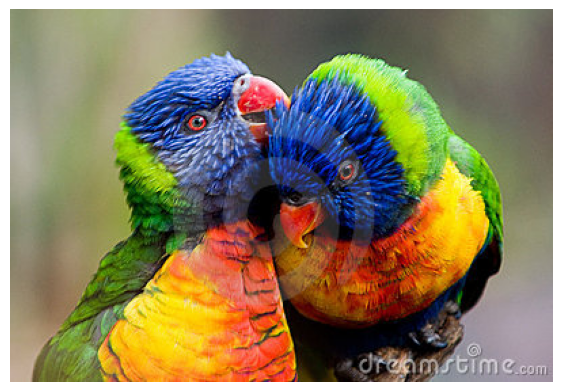

In [ ]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [ ]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


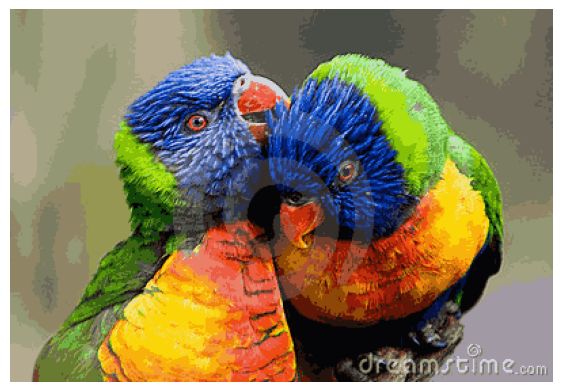

In [ ]:
X = img.reshape((-1,3)).astype(np.float32)

k = 50

kmeans = KMeans(n_clusters=k, random_state=123, n_init='auto').fit(X)

center = kmeans.cluster_centers_
center = np.uint8(center)
center.shape
label = kmeans.labels_
res = center[label.flatten()]

result_image = res.reshape((img.shape))
draw_picture(result_image)

In [ ]:
clusters_count = [2, 3, 10, 20]

**Для KMeans:**

In [ ]:
metrics = []

for k in clusters_count:

  clustering = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)

  center = clustering.cluster_centers_
  center = np.uint8(center)
  center.shape
  label = clustering.labels_
  res = center[label.flatten()]

  result_image = res.reshape((img.shape))
  ssim_score = ssim(img, result_image, data_range=(result_image.max() - result_image.min()), win_size=3)
  metrics.append(ssim_score)

metrics

[0.40892503715680323,
 0.5391339448899714,
 0.7572449529647195,
 0.840075092862132]

Полученные метрики:
0.40652949953947776, 0.5365110081330701, 0.7610014185495165, 0.8369129167817302

*   k=2 -> 0.40652949953947776
*   k=3 -> 0.5365110081330701
*   k=10 -> 0.7610014185495165
*   k=20 -> 0.8369129167817302

Максимальное значение метрики при n_clusters=20

**Для DBSCAN:**

В гиперпараметрах DBSCAN n_clusters не указывается

In [ ]:
clustering = DBSCAN(eps=5).fit(X)

center = clustering.components_
label = clustering.labels_
res = center[label.flatten()]

result_image = res.reshape((img.shape))
ssim_score = ssim(img, result_image, data_range=(result_image.max() - result_image.min()), win_size=3)
ssim_score

0.3217025500475224

Лучшим оказался KMeans.

# 2 - Пишем K-Means сами

Написать K-Means и сравнить с моделькой из под sklearn.

Задание оценивается в 5 баллов

In [ ]:
class MyKMeans:

  def __init__(self, n_clusters=8, max_iter=300, random_state=42):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.labels_ = np.array([])
    self.cluster_centers_ = np.array([])
    np.random.seed(seed=random_state)

  def fit(self, X):
      centroids = X[np.random.choice(range(len(X)), self.n_clusters, replace=False)]

      for _ in range(self.max_iter):
          labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=1)
          new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

          if np.all(centroids == new_centroids):
              break

          centroids = new_centroids

      self.cluster_centers_ = centroids
      self.labels_ = labels

  def fit_predict(self, X):
    self.fit(X)
    return self.labels_

Посмотрим, какое качество показывает моя модель для той же картинки и тех же n_clusters = {2, 3, 10, 20}

In [ ]:
metrics = []

for k in clusters_count:
  my_k_means = MyKMeans(n_clusters=k)
  label = my_k_means.fit_predict(X)
  center = my_k_means.cluster_centers_
  center = np.uint8(center)
  center.shape

  res = center[label.flatten()]

  result_image = res.reshape((img.shape))
  ssim_score = ssim(img, result_image, data_range=(result_image.max() - result_image.min()), win_size=3)
  metrics.append(ssim_score)

metrics

[0.4064373336089929,
 0.5372021142844303,
 0.7607766745462213,
 0.8630250835346234]

Качество моей модели примерно такое же как у sklearn (см. метрики для KMeans от sklearn выше)

# 3 - Пишем DBSCAN сами (дополнительное задание на 5 баллов)

Аналогично предыдудщему заданию

In [ ]:

class My_DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X):
        labels = np.zeros(len(X))
        cluster = 0

        for i in range(len(X)):
            if labels[i] != 0:
                continue

            neighbors = self.get_neighbors(X, i)

            if len(neighbors) < self.min_samples:
                labels[i] = -1
            else:
                cluster += 1
                labels[i] = cluster

                for j in neighbors:
                    if labels[j] == -1:
                        labels[j] = cluster
                    elif labels[j] == 0:
                        labels[j] = cluster
                        new_neighbors = self.get_neighbors(X, j)

                        if len(new_neighbors) >= self.min_samples:
                            neighbors = np.concatenate((neighbors, new_neighbors))

        self.labels_ = labels
        self.components_ = X[labels != -1]

    def get_neighbors(self, X, i):
        return np.where(np.linalg.norm(X - X[i], axis=1) < self.eps)[0]

Сгенерируем 3 кластера

In [ ]:
from sklearn.datasets import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

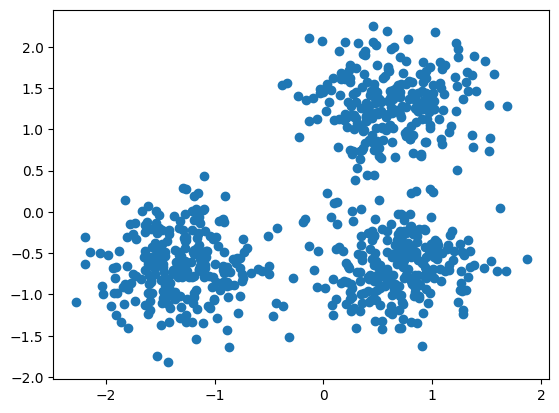

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])
plt.show()

Для моей модели:

In [ ]:
my_dbscan = My_DBSCAN(eps=1.3, min_samples=10)
my_dbscan.fit(X)
labels = my_dbscan.labels_

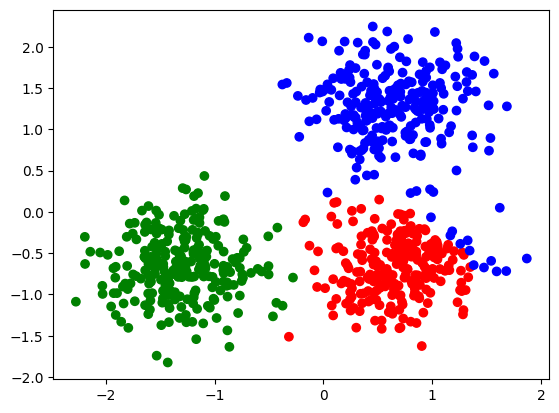

In [ ]:
colors = ['red', 'blue', 'green']
cluster_colors = [colors[int(label) % len(colors)] for label in labels]
plt.scatter(X[:, 0], X[:, 1], c=cluster_colors)
plt.show()

Для sklearn:



In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(X)
labels = dbscan.labels_

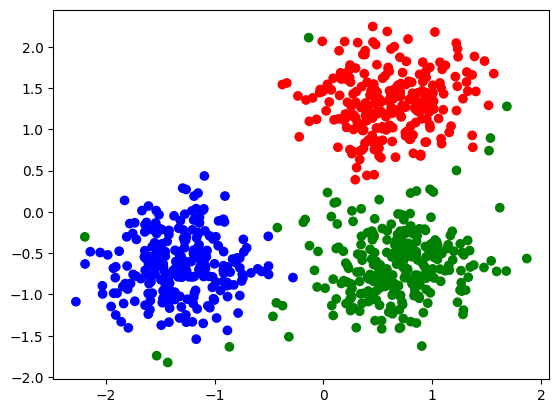

In [ ]:
colors = ['red', 'blue', 'green']
cluster_colors = [colors[int(label) % len(colors)] for label in labels]
plt.scatter(X[:, 0], X[:, 1], c=cluster_colors)
plt.show()